# Optimizing Sales with Business Decisions — Analyzing Music Market Trends and Company Sales Performances
Chinook is a fictional digital online music shop that sells a wide variety of tracks of many different genres. Consisting of only eight employees, Chinook is a small startup retail store with the goal of becoming a store customers and rely on and come back to. Being a music retail store, it acts as the middle man between buyers and the tracks they want to buy, and since Chinook is an online store, this offers great convienience for customers who want to buy tracks.

The fact that there is such a great variety of tracks from different artists and genres, Chinook needs to be mindful of their budget when purchasing tracks from record labels that they sign with and what they can do to optimize the performance of their sales. As a data analyst for Chinook, we will use SQL to find the answers we want and make the appropriate decisions that can help Chinook propel forward.

In this situation, we have 4 questions that we have been assigned to answer:
 1. Chinook has signed with a new record label; how can we determine which are the best artists to sell in our store? We will have to choose our artists by identifying which are the best performing genres in the USA.
 2. Are our Sales Support Agents doing well? This is important because our Agents directly engage with customers who have made a purchase with the store.
 3. How are our sales doing internationally? Which countries should have more priority? We will use basic summary aggregate statistics to make a conclusion.
 4. Can the company afford to save some money by limiting what we buy from our sellers? By making a large-scale aggregation with all of our sales data will we find out if this is a good idea.

# Loading the Chinook Database Into Our SQL Engine
Use the following code to connect our Jupyter Notebook to our database file.

You can download the database file here: `github link`

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

# What does our database look like?
The first thing to do is to see what the database actually consists of and if there's any views present to see what we are actually working with. First, we will briefly explore the database to gain familiarity with it and see what tables and views are present.

Here, we see that there are many tables available to work with. To making navigating through the database easier and to understand the relationship between all of the tables, we have been provided with its schema table.
![Image](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

In [2]:
%%sql
SELECT name, 
       type
FROM sqlite_master --# /*think of the entire database as a table itself 
                   --#   and call upon it by referring to it as `sqlite_master`*/
WHERE type IN ('table', 'view')

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# Which artists' tracks should we purchase?

Chinook record store has just recently signed a deal with a new record label and have been provided with artists that have not yet had their tracks included on the Chinook store before. From this new record label we are provided with 4 different artists, all presiding within a different genre. This newly signed record label specializes in artists from the USA and has given Chinook a budget to advertise these artists in the USA, so we need to be able to identify which 3 out of these 4 artists would be best to purchase for our store.

| Artist Name      | Genre |
| ----------- | ----------- |
| Regal      | Hip-Hop       |
| Red Tone   | Punk     |
| Meteor and the Girls   | Pop     |
| Slim Jim Bites  | Blues     |

Note that none of these artists have any tracks in the store right now, but we have information on what genre each artist belongs to — we can make our judgement by determining what genres perform the best in the USA based on Chinook's sales records.

In [3]:
%%sql
DROP VIEW IF EXISTS genre_view

 * sqlite:///chinook.db
Done.


[]

In [4]:
%%sql
CREATE VIEW genre_view AS 
WITH 
--# extract only USA data
usa AS
    (SELECT *
       FROM invoice_line il
       LEFT JOIN track t ON t.track_id = il.track_id
       LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
      WHERE i.billing_country = 'USA'),

--# count of each genre from the USA
--# join in `genre` table using secondary key from `track` table
genre_count AS
    (SELECT g.name,
            COUNT(g.name) AS count
       FROM usa
      INNER JOIN genre g ON g.genre_id = usa.genre_id
      GROUP BY g.name)
    
SELECT name,
       count,
       --# calculate the percentages of all genres
        ROUND(count / (
                       SELECT CAST(SUM(count) AS FLOAT)
                       FROM genre_count
                      ) * 100 , 2) AS percent
FROM genre_count
GROUP BY name
ORDER BY count DESC

 * sqlite:///chinook.db
Done.


[]

In [5]:
%%sql
SELECT *
FROM genre_view
WHERE name IN ("Hip Hop/Rap", "Alternative & Punk", "Pop", "Blues")
--# these are the genres associated with the 4 artists we just signed

 * sqlite:///chinook.db
Done.


name,count,percent
Alternative & Punk,130,12.37
Blues,36,3.43
Pop,22,2.09
Hip Hop/Rap,20,1.9


To dig deeper and see what else we can find from these results, we'll load the VIEW output into a pandas dataframe and then visualize it with matplotlib.

Text(0, 0.5, 'Genre')

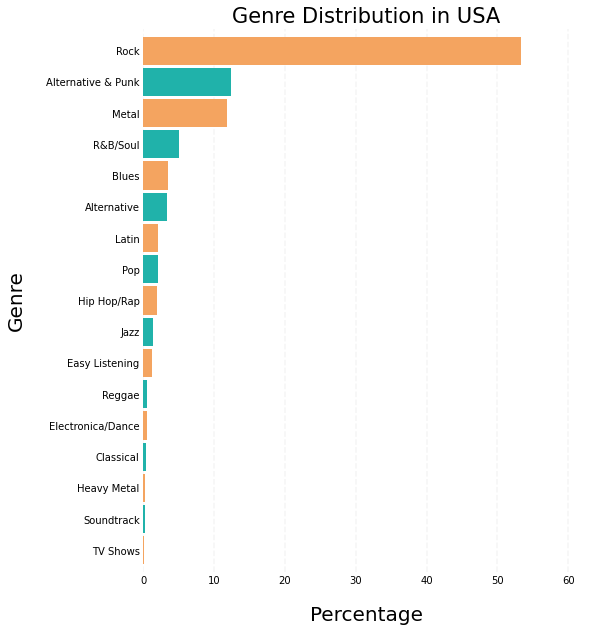

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# make database connection and read VIEW output into a pandas dataframe
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query("""SELECT *
                          FROM genre_view""", conn)

df = df.sort_values('percent')

# plot horizontal bar chart
ax = df.plot(kind='barh', x='name', y='percent', figsize=(8, 10), color={'sandybrown','lightseagreen'}, 
             zorder=2, width=0.9)

# set the title
ax.set_title("Genre Distribution in USA", size=21)

# remove all spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# hide ticks and legend
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_legend().remove()

# draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.6, color='#eeeeee', zorder=1)

# set labels
ax.set_xlabel("Percentage", labelpad=20, size=20)
ax.set_ylabel("Genre", labelpad=20, size=20)

From the list of 4 artists we have been provided, I recommend purchasing tracks by "Red Tone", "Slim Jim Bites", and "Meteor and the Girls". I also recommend on placing more emphasis on tracks from "Red Tone", since the "Alternative & Punk" genre has sold an average of 104 more tracks than the other genres and is in second place in most tracks sold in the USA, right behind "Rock". 

In addition, for future decisions, it would be also best to try to purchase tracks from the "Rock" genre as much as possible, since this genre makes up over 50% of the store's sales in the USA!

# Is there any room for improvement for our employees?

Chinook highly values reliable engagement with our customers. Whenever a new customer makes their first purchase on the Chinook store, they get assigned to a sales support agent within the company. Because of this direct engagement with the customers, we want to see if there's any sales agent that's underperforming or doing exceptionally well. We also want to see if there are any variation in possible factors that could affect their performance so that the proper adjustments to assist our sales agents in producing more revenue.

Although there is a slight variance in the performance of our sales support agents, there is nothing out of place to take note of or anything to worry about. The variance between the median sales among the sales support agents is +-\\$200, and this be explained by the hire dates we also decided to extract. Jane Peacock had the most sales at \\$1731.51 and Steve Johnson brought in \\$1393.92 in sales, with Margaret Park being the median at \\$1584.00. 

In [7]:
%%sql
--# concatenate `first_name` and `last_name` columns to get full names of each employee
WITH sales_employees AS
    (SELECT employee_id,
           first_name || ' ' || last_name AS employee_name,
           hire_date
      FROM employee
     WHERE title = 'Sales Support Agent')
    
--# connect customers' total sales to each employee by joining in `customer` and `invoice` tables
--# group total sales by employee
SELECT e.employee_name,
       ROUND(SUM(i.total), 2) AS total_sales,
       hire_date
FROM sales_employees e
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
LEFT JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY e.employee_name

 * sqlite:///chinook.db
Done.


employee_name,total_sales,hire_date
Jane Peacock,1731.51,2017-04-01 00:00:00
Margaret Park,1584.0,2017-05-03 00:00:00
Steve Johnson,1393.92,2017-10-17 00:00:00


We can see a trend that the earlier the hire date, the more sales. The later the hire date, the less sales. We can infer that someone who was hired at an earlier date was able to have more time to bring in more sales, but also have more time to gain more experience in doing so — someone hired at a later date has just started out, so they can't really be expected to bring in just as much sales as someone more experienced.

I believe that our sales support agents are already doing well to the best of their abilities. It is only a matter of providing them enough time to build the experience necessary to bring in as much as sales as our best performing employee.

# In which country does Chinook perform the best in?

As an online digital music shop, Chinook is able to draw in customers from nearly anywhere in the world. We want to know how our sales are doing from across all the countries our customers live in. Which countries do we consider as outliers? Which countries should have more priority based on their total sales? We have been advised to take careful consideration to refer to the `country` value from the customers table, not the `country` value from the billing address in the invoice table.

We will use basic summary aggregate statistics by finding (for each country) the total number of customers, the total sales, the average value of a customer, and the average value per order to make a conclusion. Note that there are many countries with only one customer — these will be our outlier countries. To make our analysis easier to read, we will aggregate all countries with one customer into a value in the `country` column as "Other".

We have found that the top 5 countries that generates the most sales for Chinook are: the USA, Canada, Brazil, France, and Germany. With the USA holding the highest number of our customers (by country) at 13 customers and also generating 22.1% of all our sales, the USA should be the most important country our customers are from. It should also be of importance that the Czech Republic has the highest average value per customer at \\$136.62, meaning customers from the Czech Republic has the highest WTP (willingness to pay) amongst all of our countries.

In [8]:
%%sql
--# important to get required columns first, and then later categorize countries with one customer as "Other"
WITH country_customer AS 
    (SELECT c.customer_id,
            i.invoice_id,
            i.total,
            CASE
                WHEN (
                     SELECT COUNT(*)
                     FROM customer
                     WHERE country = c.country
                     --# /*WHERE `country` from the inner query is equal to `country`
                     --#   from the outer query*/
                     ) = 1 THEN "Other"
                ELSE c.country
            END AS country --# this will be our `country` column from the `customer` table, not `invoice`
    FROM invoice i
    LEFT JOIN customer c ON c.customer_id = i.customer_id)

SELECT country,
       number_of_customers,
       total_sales,
       avg_value_per_customer,
       avg_value_per_order
FROM (  --# /*will need to query out of this subquery so that we don't see the sort column, 
        --#   but "Other" is still forced to the bottom*/
        SELECT country,
           --# summary statistics calculations to get the final required data
               COUNT(DISTINCT(customer_id)) AS number_of_customers,
               ROUND(SUM(total), 2) AS total_sales,
               ROUND(SUM(total) / COUNT(DISTINCT(customer_id)), 2) AS avg_value_per_customer,
               ROUND(SUM(total) / COUNT(DISTINCT(invoice_id)), 2) AS avg_value_per_order,
               CASE --# force the ordering of "Other" by creating a "unseen" sorting column
                   WHEN country = 'Other' THEN 1
                   ELSE 0
               END AS sort
        FROM country_customer
        GROUP BY country
        ORDER BY sort, total_sales DESC
     )

 * sqlite:///chinook.db
Done.


country,number_of_customers,total_sales,avg_value_per_customer,avg_value_per_order
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Other,15,1094.94,73.0,7.45


# Can we afford to take some shortcuts to save money?
The Chinook store is structured in such a way that customers can only make purchases one of two ways: either purchase a whole album or purchase a collage of one or more individual tracks. In addition, customers are not allowed to make an album purchase and then add a couple more individual tracks onto the same invoice and vice versa. However, purchasing an entire album is not at all any more expensive or cheaper than if one were to purchase all the tracks of an album separately as individual tracks (previous analyses have already showed customers don't have a history of doing this).

Management at Chinook wants to find a way to somehow save money. To do that, they are proposing purchasing only the most popular tracks from an album instead of all the tracks from said album. It is up to us, as data analysts, with being tasked to find out if this is really a good idea. We have been instructed to find out what percentage of purchases are individual tracks vs entire albums so that management can use this data to see whether this change in purchasing strategy will have some sort of effect on overall revenue.

In [9]:
%%sql
--# start by creating a subquery that finds the first track of an album for each invoice
--# will use these first tracks to find the album associated with each invoice
WITH invoice_first_track AS
(
SELECT il.invoice_id, 
       MIN(il.track_id) AS first_track_id
FROM invoice_line il
GROUP BY il.invoice_id
)

SELECT album_purchase,
       COUNT(invoice_id) AS number_of_invoices,
    --# calculate percentages (this is what we really want)
        ROUND(CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT (*)
                                                 FROM invoice), 3) AS percent
FROM (
    SELECT ifs.*,
           --# /*using a CASE statement, create an entire new column that categorizes 
           --#   every invoice as either an album or individual track purchase*/
           CASE WHEN (--# list of tracks from album
                      SELECT t.track_id
                      FROM track t
                      WHERE t.album_id = (SELECT t2.album_id
                                          FROM track t2
                                          WHERE t2.track_id = ifs.first_track_id)

                      EXCEPT

                      --# list of tracks from invoice
                      SELECT il2.track_id
                      FROM invoice_line il2
                      WHERE il2.invoice_id = ifs.invoice_id) IS NULL

                      AND --# use same queries but switch ordering use in second EXCEPT
                          --# /*want to see if NULL AND NULL (album) or
                          --#   either NULL AND NOT NULL or NOT NULL AND NULL (not album)*/

                     (--# list of tracks from invoice
                      SELECT il2.track_id
                      FROM invoice_line il2
                      WHERE il2.invoice_id = ifs.invoice_id

                      EXCEPT

                      --# list of tracks from album
                      SELECT t.track_id
                      FROM track t
                      WHERE t.album_id = (SELECT t2.album_id
                                          FROM track t2
                                          WHERE t2.track_id = ifs.first_track_id)) IS NULL
                THEN "yes" --# /*if result is NULL AND NULL or True (is an album, 
                           --#   list of tracks in invoice has all tracks in album)*/
                
                ELSE "no"  --# /*if result is NULL AND NOT NULL or False (not an album,
                           --#   invoice has missing tracks/remainder tracks present in album tracklist
                           --#   when subtracting invoice tracklist from album tracklist)*/
           END AS "album_purchase"
    FROM invoice_first_track ifs
    )
GROUP BY album_purchase

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,0.814
yes,114,0.186


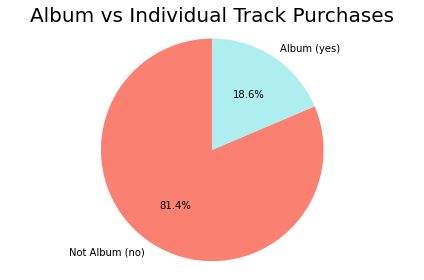

In [10]:
# plot output into a pie chart
import matplotlib.pyplot as plt

labels = ['Not Album (no)', 'Album (yes)']
sizes = [81.4, 18.6]
colors = ['salmon','paleturquoise']

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.title('Album vs Individual Track Purchases', size=20)
plt.tight_layout()
plt.show()

After aggregating all of our data into categories of whether they are album or individual track purchases, we have found that 81.4% of all invoices are individual track purchases, while 18.6% of invoices are album purchases.

I would heavily advise against not purchasing entire albums from record labels as we could lose up to 20% of all our revenue by going down that path. It is far too risky to wager losing nearly 20% of revenue just to save some money when purchasing tracks or albums.

# Conclusion
Chinook wants to be mindful of their budget and be able to make good business decisions that can optimize sales. It is a small and relatively new business, so it must be able to avoid any slipups and make good decisions with where and how its money should be allocated. It is our job, as data analysts to use data to clearly provide and communicate to Chinook management the information they need to make informed business decisions. 

We were able to find all of what we were looking for by querying out of the Chinook database with very specific criteria and calculations using SQL. Using the data we already have, we obtained a better idea of what genre of music our American customers like, the sales performance of our employees, our international sales, and a mass categorization/aggregation of all of our invoices.  From these insights, we were able to make better decisions and know exactly what to do and not what to do when making track or album purchases with partnered record labels as well as where we should direct our energy and attention to how we should sell our music.

# Acknowledgements
This is a guided project from the online data science learning platform "Dataquest". 
 - https://app.dataquest.io/m/256/querying-sqlite-from-python/1/overview

Chinook music store and the data used in this project are entirely fictional.